# Assignment 3 - Building a Custom Visualization

---

In this assignment you must choose one of the options presented below and submit a visual as well as your source code for peer grading. The details of how you solve the assignment are up to you, although your assignment must use matplotlib so that your peers can evaluate your work. The options differ in challenge level, but there are no grades associated with the challenge level you chose. However, your peers will be asked to ensure you at least met a minimum quality for a given technique in order to pass. Implement the technique fully (or exceed it!) and you should be able to earn full grades for the assignment.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean (see the boxplot lectures for more information, and the yerr parameter of barcharts).

<br>
<img src="readonly/Assignment3Fig1.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Figure 1 from (Ferreira et al, 2014).</h4>

<br>

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem (Figure 2c) is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.


<br>
<img src="readonly/Assignment3Fig2c.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  Figure 2c from (Ferreira et al. 2014). Note that the colorbar legend at the bottom as well as the arrows are not required in the assignment descriptions below.</h4>

<br>
<br>

**Easiest option:** Implement the bar coloring as described above - a color scale with only three colors, (e.g. blue, white, and red). Assume the user provides the y axis value of interest as a parameter or variable.


**Harder option:** Implement the bar coloring as described in the paper, where the color of the bar is actually based on the amount of data covered (e.g. a gradient ranging from dark blue for the distribution being certainly below this y-axis, to white if the value is certainly contained, to dark red if the value is certainly not contained as the distribution is above the axis).

**Even Harder option:** Add interactivity to the above, which allows the user to click on the y axis to set the value of interest. The bar colors should change with respect to what value the user has selected.

**Hardest option:** Allow the user to interactively set a range of y values they are interested in, and recolor based on this (e.g. a y-axis band, see the paper for more details).

---

*Note: The data given for this assignment is not the same as the data used in the article and as a result the visualizations may look a little different.*

In [4]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats as st

In [5]:
# Use the following data for this assignment:
np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])

In [6]:
# Compute descriptive statistics
def get_ci(df, sig):
    ci = []
    for index, row in df.iterrows():
        ci.append(st.t.interval(sig, len(df.loc[index])-2, loc=np.mean(df.loc[index]), scale=st.sem(df.loc[index])))
    return ci

def get_stats(df):
    means = np.mean(np.array(df), axis = 1)
    sem =  st.sem(np.array(df), axis = 1)
    ci = np.array(get_ci(df, sig = 0.95))
    yerr = np.c_[means-ci[:,0],ci[:,1]-means ].T
    return means, sem, ci, yerr

In [7]:
# Designate colors
def get_colors(y, ci):
    colors = []
    for interval in ci:
        if y < interval[0]:
            colors.append('darkblue')
        elif y > interval[1]:
            colors.append('crimson')
        else:
            colors.append('w')
    return(colors)

<IPython.core.display.Javascript object>


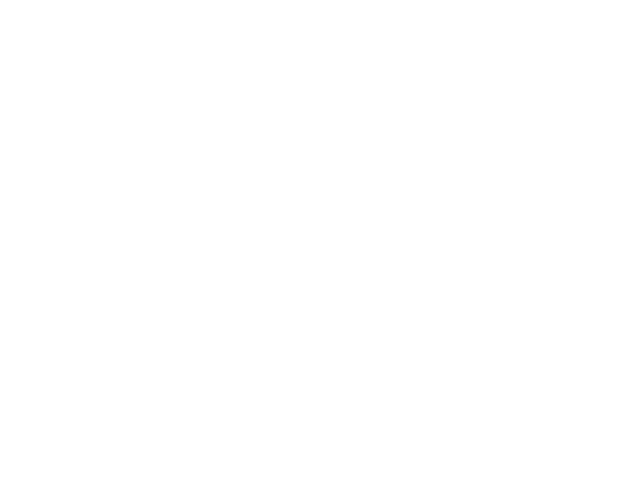

In [8]:
# Easy Plot
def plot1(y, df):
    
    # Obtain statistics
    means, sem, ci, yerr = get_stats(df)
    
    # Designate basic bar chart parameters
    x = np.arange(len(means))  # the x locations for the groups
    width = 1  # the width of the bars
    opacity = 1
    
    # Build figure, axes and bar charts
    fig, ax = plt.subplots()
    bars = ax.bar(x, means, width, yerr = yerr, alpha = opacity,
                  color = get_colors(y, ci), linewidth = 1.0,
                 edgecolor = 'black', capsize = 5)
    ax.axhline(y)
    ax.set_xlabel('Years')
    ax.set_ylabel('Scores')
    ax.set_title('Sample Visualization One')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(('1992', '1993', '1994', '1995'))
    plt.show()
plot1(y = 55000, df = df)

In [9]:
# Determine coverage
def get_coverage(y, ci):
    coverage = []
    for interval in ci:
        if y < interval[0]:
            coverage.append(1)
        elif y > interval[1]:
            coverage.append(0)
        else:
            c = (interval[1] - y) / (interval[1] - interval[0])
            coverage.append(c)
    return(coverage)

In [10]:
# Harder Chart
def plot2(y, df):
    means, sem, ci, yerr = get_stats(df)
    coverage = np.array(get_coverage(y = y, ci = get_ci(df, 0.95)))
    colors = cm.RdBu_r(coverage)
    plot = plt.scatter(coverage, coverage, c = coverage, cmap = 'RdBu_r')
    plt.clf()
    plt.colorbar(plot)
    plt.bar(range(len(means)), means, color = colors, yerr = yerr, 
                  linewidth = 1.0, edgecolor = 'black', capsize = 5)
    plt.axhline(y = y)
    plt.xlabel('Years')
    plt.ylabel('Scores')
    plt.title('Sample Visualization Two')
    plt.xticks(np.arange(4), ('1992', '1993', '1994', '1995'))
    plt.show()
plot2(y = 35000, df = df)

In [11]:
def plot2(y, df):
    means, sem, ci, yerr = get_stats(df)
    coverage = np.array(get_coverage(y = y, ci = get_ci(df, 0.95)))
    colors = cm.RdBu_r(coverage)
    
    x = np.arange(len(means))  # the x locations for the groups
    width = 1  # the width of the bars
    opacity = 1
    
    # Build figure, axes and bar charts
    fig, ax = plt.subplots()
    plot = ax.scatter(coverage, coverage, c = coverage, cmap = 'RdBu_r')
    #fig.clf()
    fig.colorbar(plot)
    ax.bar(range(len(means)), means, color = colors, yerr = yerr, 
                  linewidth = 1.0, edgecolor = 'black', capsize = 5)
    ax.axhline(y)
    ax.set_xlabel('Years')
    ax.set_ylabel('Scores')
    ax.set_title('Sample Visualization Three')
    ax.set_xticks(x)
    ax.set_xticklabels(('1992', '1993', '1994', '1995'))
    return(ax.bar)

<IPython.core.display.Javascript object>


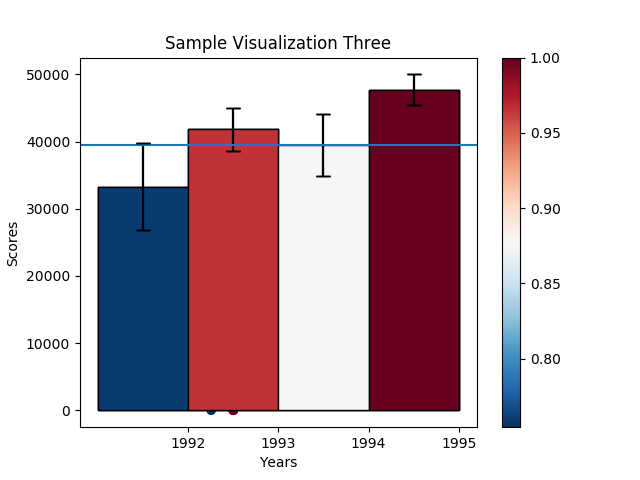

In [17]:
class Plot3():
    
    def __init__(self, df = df, y = 30000, clicklim = 0.05):
        
        # Obtain stats and colors
        self.y = y
        self.means, self.sem, self.ci, self.yerr = get_stats(df)
        self.coverage = np.array(get_coverage(y = self.y, ci = get_ci(df, 0.95)))
        self.colors = cm.RdBu_r(self.coverage)
        
        # Obtain figure and axis object
        self.fig, self.ax = plt.subplots()
        
        # Set width of errorbar caps
        self.cap = 5
        
        # Set width of bars
        self.width = 1
        
        # Set location of bars
        self.locs = np.arange(len(self.means))  
        
        # Set click limit        
        self.clicklim = clicklim
        
        # Set horizontal line
        self.horizontal_line = self.ax.axhline(30000)
        
        # Create color bar
        plot = self.ax.scatter(self.coverage, self.coverage, c = self.coverage, cmap = 'RdBu_r')
        self.fig.colorbar(plot)
        
        # Render bars
        self.bars = self.ax.bar(self.locs, self.means, color = self.colors, 
                                yerr = self.yerr, linewidth = 1.0, 
                                edgecolor = 'black', capsize = self.cap, 
                                width = self.width)
        
        # Set up labels for bars
        self.ax.set_xticks(self.locs + self.width / 2)
        self.ax.set_xticklabels(('1992', '1993', '1994', '1995'))
        
        # Set x and y labels and title
        self.ax.set_xlabel('Years')
        self.ax.set_ylabel('Scores')
        self.ax.set_title('Sample Visualization Three')
        
        self.fig.canvas.draw()
        # Connect to event
        self.fig.canvas.mpl_connect('button_press_event', self.onclick)

    def onclick(self, event):
        if event.inaxes == self.ax:
            x = event.xdata
            y = event.ydata
            xlim0, xlim1 = self.ax.get_xlim()
            if x <= xlim0+(xlim1-xlim0)*self.clicklim:
                self.horizontal_line.set_ydata(y)
                self.means, self.sem, self.ci, self.yerr = get_stats(df)
                self.coverage = np.array(get_coverage(y = y, ci = get_ci(df, 0.95)))
                self.colors = cm.RdBu_r(self.coverage)
                self.bars = self.ax.bar(self.locs, self.means, color = self.colors, 
                                yerr = self.yerr, linewidth = 1.0, 
                                edgecolor = 'black', capsize = self.cap, 
                                width = self.width)
                # Set up labels for bars
                self.ax.set_xticks(self.locs + self.width / 2)
                self.ax.set_xticklabels(('1992', '1993', '1994', '1995'))
        
                # Set x and y labels and title
                self.ax.set_xlabel('Years')
                self.ax.set_ylabel('Scores')
                self.ax.set_title('Sample Visualization Three')
                self.fig.canvas.draw()
                
%matplotlib notebook
p3 = Plot3(df = df)
plt.show()